HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

Text(0.5, 1.0, 'Estados del segway')

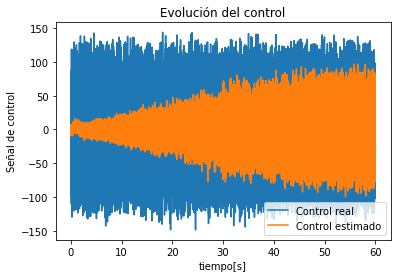

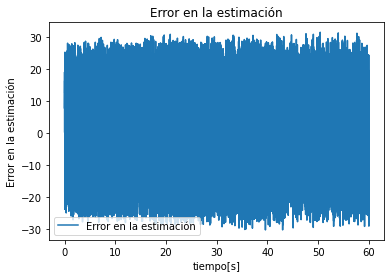

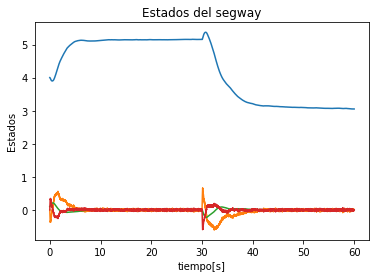

In [6]:
import importlib
import numpy as np
import nengo
import matplotlib.pyplot as plt
import segway; importlib.reload(segway)


estado_inicial = np.array([4.,0., 0.1, 0.])  #condiciones iniciales q
estado_deseado = np.array([6., 0., 0., 0.])
estado_deseado2 = np.array([4., 0., 0., 0.])

segway_sim = segway.SegwayLink(dt = 1e-3)
segway_sim.init_q = estado_inicial
segway_sim.reset()

model = nengo.Network(seed=0)
with model:
    #creando el nodo del segway
    model.segway_node = segway_sim.create_nengo_node()
    #creando la referencia
    model.ref = nengo.Network('REF')
    with model.ref:
        def PMC_func(t):
            if t<30:
                return estado_deseado
            return estado_deseado2
        model.ref.output = nengo.Node(output = PMC_func, label = 'Referencia')

    #enviando la referencia al nodo segway para graficarla
    nengo.Connection(model.ref.output[0], model.segway_node[1])
    nengo.Connection(model.ref.output[2], model.segway_node[2])

    model.error = nengo.Ensemble(300,4, radius = 3.1416, label = 'Error')



    #creando un ensamble que mapee los estados del segway a la red
    model.cerebelo = nengo.Ensemble(1000, 4, radius = 10)

     #creando nodo de control
    model.u = nengo.Ensemble(1000,4, radius = 350)

    #envia el estado deseado al nodo error (transform = -1 es para restar x - xd)
    nengo.Connection(model.ref.output, model.error, transform = -1)

    #conectando la salida [dq0, ddq0, dq1, ddq1] del segway al cerebelo
    nengo.Connection(model.segway_node[:4], model.cerebelo)
    #conectando la salida del segway al error
    nengo.Connection(model.cerebelo, model.error)

    nengo.Connection(model.error, model.u, transform = [100,323.3434,542.0927,541.08])


    model.u_sum = nengo.Ensemble(1000,1,radius=50)
    nengo.Connection(model.u[0], model.u_sum)
    nengo.Connection(model.u[1], model.u_sum)
    nengo.Connection(model.u[2], model.u_sum)
    nengo.Connection(model.u[3], model.u_sum)
    #enviando la señal de control
    nengo.Connection(model.u_sum, model.segway_node[0])

    #creando nodo de control aprendido
    model.u_est = nengo.Ensemble(1000,1,radius=50)
    conn = nengo.Connection(model.u_sum, model.u_est, function=lambda x: np.random.random())
    model.error_u = nengo.Ensemble(500, 1, radius = 10)
    nengo.Connection(model.u_sum,model.error_u, transform=-1)
    nengo.Connection(model.u_est, model.error_u)
    # Add the learning rule to the connection
    conn.learning_rule_type = nengo.PES()

    # Connect the error into the learning rule
    nengo.Connection(model.error_u, conn.learning_rule)
    #mandando probes
    data_usum = nengo.Probe(model.u_sum)
    data_uest = nengo.Probe(model.u_est)
    data_erroru = nengo.Probe(model.error_u)
    data_estados = nengo.Probe(model.segway_node[:4])



with nengo.Simulator(model) as sim:
    sim.run(60.0)

fig1, (axs1) = plt.subplots(1)
axs1.plot(sim.trange(), sim.data[data_usum], label = "Control real")
axs1.plot(sim.trange(), sim.data[data_uest], label = "Control estimado")
axs1.legend()
axs1.set(xlabel = 'tiempo[s]' , ylabel = 'Señal de control')
axs1.set_title('Evolución del control')

fig2, (axs2) = plt.subplots(1)
axs2.plot(sim.trange(), sim.data[data_erroru], label = "Error en la estimación")
axs2.legend()
axs2.set(xlabel = 'tiempo[s]' , ylabel = 'Error en la estimación')
axs2.set_title('Error en la estimación')

fig3, (axs3) = plt.subplots(1)
axs3.plot(sim.trange(), sim.data[data_estados], label = ["q0", "dq0", "q1", "dq1"])
axs3.set(xlabel = 'tiempo[s]' , ylabel = 'Estados')
axs3.set_title('Estados del segway')




   

    


